<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sin-trajectory" data-toc-modified-id="Sin-trajectory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sin trajectory</a></span><ul class="toc-item"><li><span><a href="#unified-quantile" data-toc-modified-id="unified-quantile-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>unified quantile</a></span></li><li><span><a href="#single-trajectory" data-toc-modified-id="single-trajectory-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>single trajectory</a></span></li><li><span><a href="#use-priori" data-toc-modified-id="use-priori-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>use priori</a></span></li></ul></li><li><span><a href="#Lorenz-trajectory" data-toc-modified-id="Lorenz-trajectory-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Lorenz trajectory</a></span><ul class="toc-item"><li><span><a href="#unified-quantile" data-toc-modified-id="unified-quantile-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>unified quantile</a></span></li><li><span><a href="#single-trajectory" data-toc-modified-id="single-trajectory-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>single trajectory</a></span></li><li><span><a href="#use-priori" data-toc-modified-id="use-priori-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>use priori</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tqdm.auto import tqdm

import random

In [2]:
from sklearn.cluster import DBSCAN

from src.Lorentz import Lorentz
from src.TSProcessor import TSProcessor

%load_ext autoreload
%autoreload 2

In [3]:
from src.utils import normalize, denormalize, plot_trajectories, gen_sin_wave

## Sin trajectory

In [145]:
train_periods = 4
test_periods = 2
points_per_period = 50
train_size = train_periods * points_per_period
test_size = test_periods * points_per_period
h_max = test_size # max prediction horizon (t+h)

points_in_template = 4
max_template_spread = 10 # max distance between y_t1 and y_t2, y_1 and y_11


# trajectories prediction parameters
eps   = 0.01
n_trajectories = 24
noise_amp = 0.05
priori_eps = 0.1


# unified prediction parameters
dbs_eps = 0.01
dbs_min_samples = 4

alpha = 0.3
max_err = 0.1
min_trajectories = int(0.5*n_trajectories)

In [146]:
x = gen_sin_wave(train_periods, test_periods, points_per_period)
x, x_min, x_max = normalize(x)

X_train = x[:train_size]
X_test = x[train_size:]
X_start = X_train[-max_template_spread * (points_in_template-1):]
X_fill = np.repeat(np.nan, h_max)

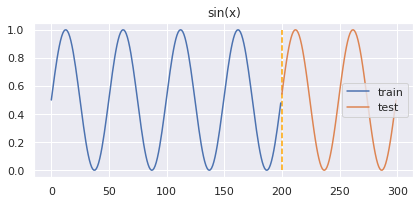

In [147]:
fig = plt.figure(figsize=[6, 3])
plt.plot(X_train, label='train')
plt.plot(range(train_size, train_size+test_size), X_test, label='test')

plt.title('sin(x)')

plt.vlines(train_size, 0, 1,
           color='orange', linestyle='dashed')

plt.legend();
fig.tight_layout()

In [148]:
tsp = TSProcessor(
    points_in_template=points_in_template,
    max_template_spread=max_template_spread)
tsp.fit(X_train)

### unified quantile

In [149]:
X_traj_pred = tsp.predict_trajectories(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    use_priori=False,
    X_test=None,
    priori_eps=priori_eps,
    save_first_type_non_pred=False,
    random_seed=1,
    n_jobs=-1,
)

5.08s


In [150]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='quantile',
    use_priori=False,
    X_test=None,
    priori_eps=priori_eps,
    min_trajectories=min_trajectories,
    max_err=max_err,
    alpha=alpha,
    dbs_eps=0.01,
    dbs_min_samples=4,
)
X_pred = unified_result['X_pred']
qs = unified_result['qs']
traj_alive = unified_result['traj_alive']

In [151]:
non_pred = np.cumsum(np.isnan(X_pred).astype(int))
pred = np.cumsum(1 - np.isnan(X_pred).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((X_pred - X_test[:h_max])**2), nan=0)) /pred

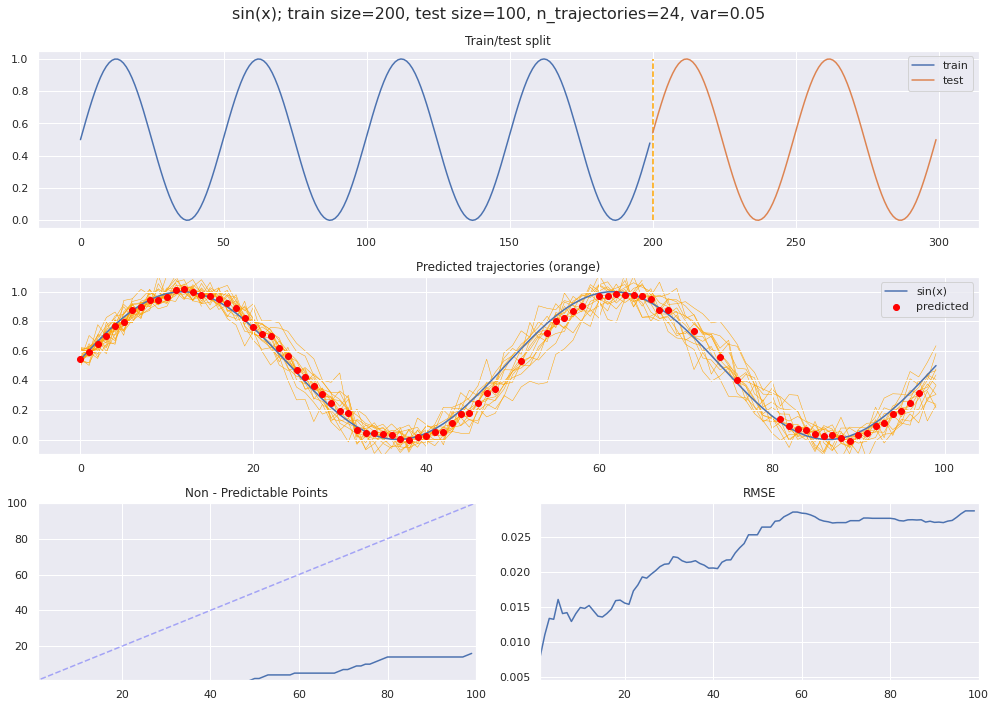

In [152]:
plot_trajectories(
    'sin(x)', X_train, X_test,
    noise_amp, n_trajectories,
    X_traj_pred, X_pred, non_pred, rmse
)

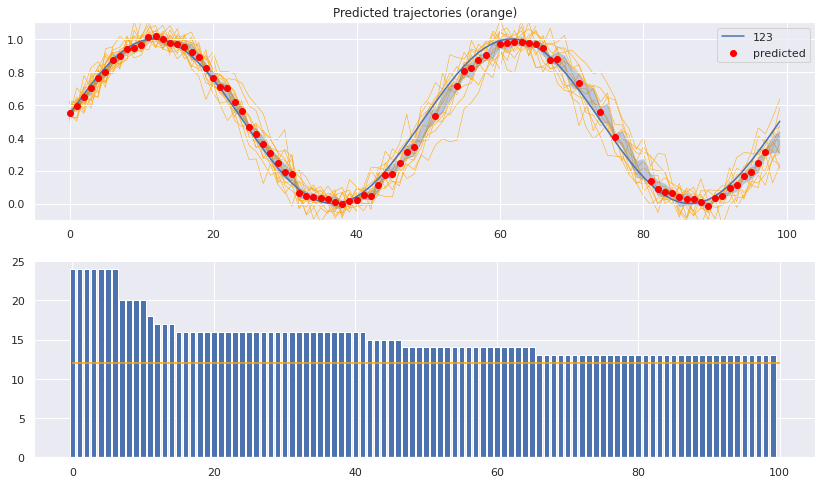

In [153]:
fig = plt.figure(figsize=[14, 8])

plt.subplot(2, 1, 1)
plt.plot(X_test, label='123', zorder=1)

plt.ylim(-0.1, 1.1)

for i in range(n_trajectories):
    plt.plot(X_traj_pred[:, i], c='orange', lw=0.5, zorder=0)

plt.scatter(range(X_pred.size),
            X_pred,
            label='predicted',
            c='red',
            zorder=2)

plt.fill_between(range(len(qs)), qs[:, 0], qs[:, 1], alpha=0.3)

plt.title('Predicted trajectories (orange)')
plt.legend(loc='upper right');

plt.subplot(2, 1, 2)
plt.bar(range(len(traj_alive)), traj_alive)
plt.hlines(y=min_trajectories, xmin=0, xmax=len(traj_alive), color='orange')

### single trajectory

In [154]:
X_traj_pred = tsp.predict_trajectories(
    X_start, h_max,
    eps=eps,
    n_trajectories=1,
    noise_amp=0,
    use_priori=False,
    X_test=None,
    priori_eps=priori_eps,
    save_first_type_non_pred=True,
    random_seed=1,
    n_jobs=-1,
)

0.64s


In [155]:
X_pred = X_traj_pred[:, 0]

In [156]:
non_pred = np.cumsum(np.isnan(X_pred).astype(int))
pred = np.cumsum(1 - np.isnan(X_pred).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((X_pred - X_test[:h_max])**2), nan=0)) /pred

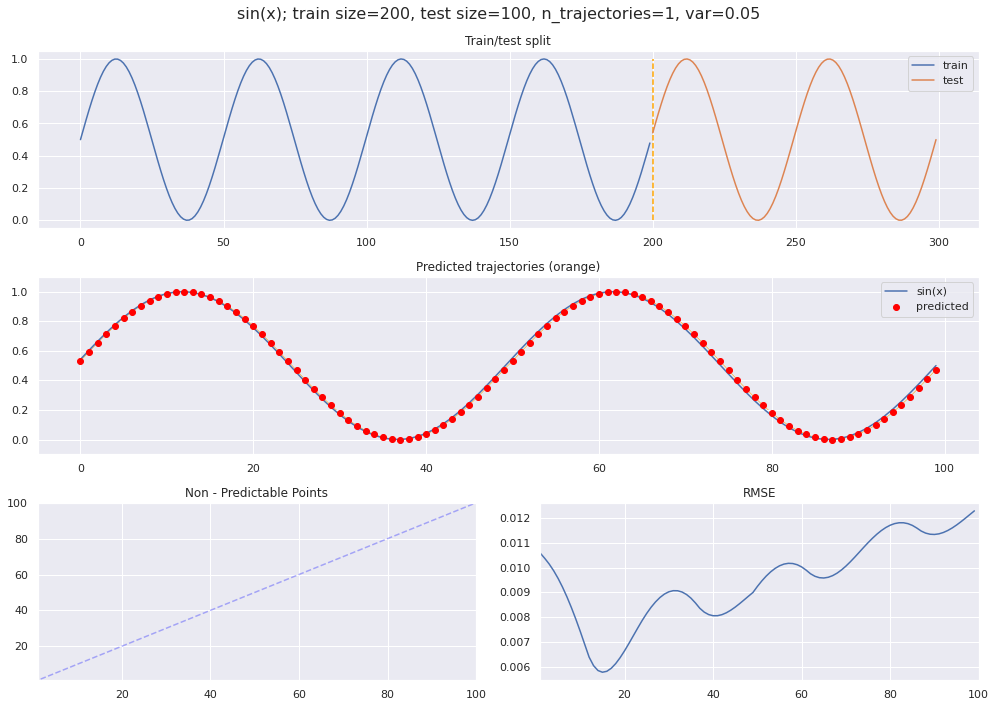

In [157]:
plot_trajectories(
    'sin(x)', X_train, X_test,
    noise_amp, 1,
    X_traj_pred, X_pred, non_pred, rmse
)

### use priori

In [158]:
X_traj_pred = tsp.predict_trajectories(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    use_priori=True,
    X_test=X_test,
    priori_eps=priori_eps,
    save_first_type_non_pred=False,
    random_seed=1,
    n_jobs=-1,
)

5.10s


In [159]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='quantile',
    use_priori=True,
    X_test=X_test,
    priori_eps=priori_eps,
    min_trajectories=min_trajectories,
    max_err=max_err,
    alpha=alpha,
    dbs_eps=0.01,
    dbs_min_samples=4,
)
X_pred = unified_result['X_pred']
qs = unified_result['qs']
traj_alive = unified_result['traj_alive']

In [160]:
non_pred = np.cumsum(np.isnan(X_pred).astype(int))
pred = np.cumsum(1 - np.isnan(X_pred).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((X_pred - X_test[:h_max])**2), nan=0)) /pred

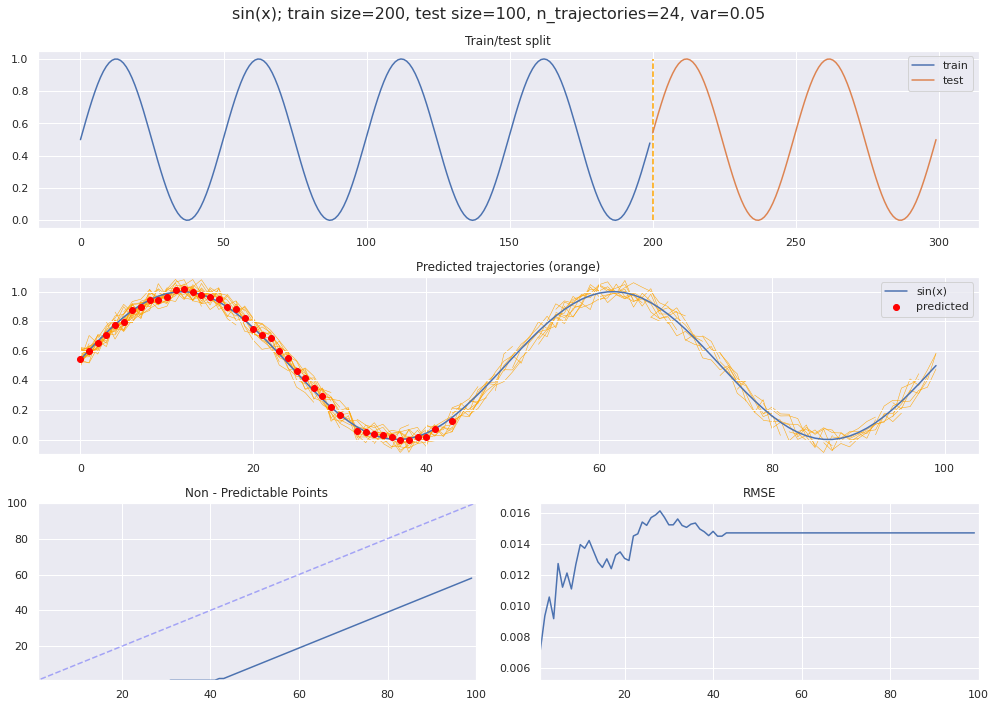

In [161]:
plot_trajectories(
    'sin(x)', X_train, X_test,
    noise_amp, n_trajectories,
    X_traj_pred, X_pred, non_pred, rmse
)

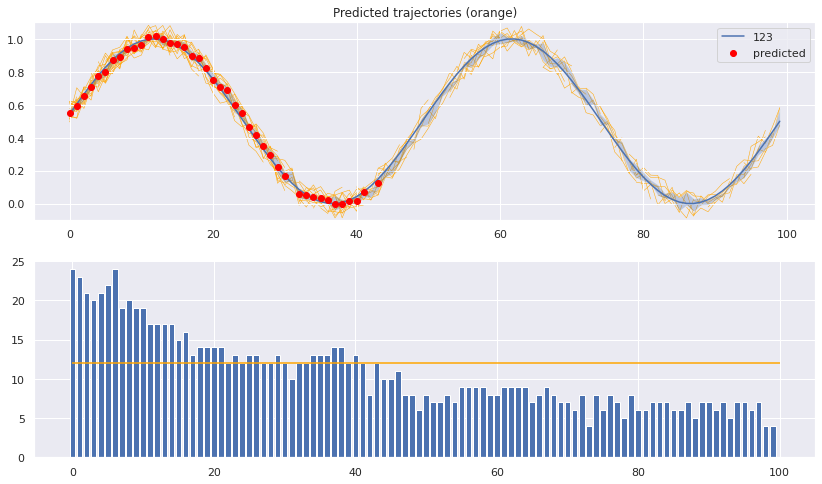

In [162]:
fig = plt.figure(figsize=[14, 8])

plt.subplot(2, 1, 1)
plt.plot(X_test, label='123', zorder=1)

plt.ylim(-0.1, 1.1)

for i in range(n_trajectories):
    plt.plot(X_traj_pred[:, i], c='orange', lw=0.5, zorder=0)

plt.scatter(range(X_pred.size),
            X_pred,
            label='predicted',
            c='red',
            zorder=2)

plt.fill_between(range(len(qs)), qs[:, 0], qs[:, 1], alpha=0.3)

plt.title('Predicted trajectories (orange)')
plt.legend(loc='upper right');

plt.subplot(2, 1, 2)
plt.bar(range(len(traj_alive)), traj_alive)
plt.hlines(y=min_trajectories, xmin=0, xmax=len(traj_alive), color='orange')

## Lorenz trajectory

In [187]:
train_size = 1000
test_size = 100
h_max = test_size # max prediction horizon (t+h)

points_in_template = 4
max_template_spread = 10 # max distance between y_t1 and y_t2, y_1 and y_11


# trajectories prediction parameters
eps   = 0.01
n_trajectories = 24
noise_amp = 0.05
priori_eps = 0.1


# unified prediction parameters
dbs_eps = 0.01
dbs_min_samples = 4

alpha = 0.3
max_err = 0.05
min_trajectories = int(0.5*n_trajectories)

In [177]:
x, _, _ = Lorentz().generate(0.1, 3000+train_size+test_size-1) # -1 because of an implementation bug
x, x_min, x_max = normalize(x[3000:]) # "For the Lorenz series, the first 3000 observations are discarded..."

X_train = x[:train_size]
X_test = x[train_size:]
X_start = X_train[-max_template_spread * (points_in_template-1):]
X_fill = np.repeat(np.nan, h_max)

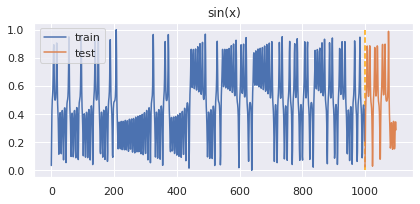

In [179]:
fig = plt.figure(figsize=[6, 3])
plt.plot(X_train, label='train')
plt.plot(range(train_size, train_size+test_size), X_test, label='test')

plt.title('sin(x)')

plt.vlines(train_size, 0, 1,
           color='orange', linestyle='dashed')

plt.legend();
fig.tight_layout()

In [180]:
tsp = TSProcessor(
    points_in_template=points_in_template,
    max_template_spread=max_template_spread)
tsp.fit(X_train)

### unified quantile

In [181]:
X_traj_pred = tsp.predict_trajectories(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    use_priori=False,
    X_test=None,
    priori_eps=priori_eps,
    save_first_type_non_pred=False,
    random_seed=1,
    n_jobs=-1,
)

25.44s


In [189]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='quantile',
    use_priori=False,
    X_test=None,
    priori_eps=priori_eps,
    min_trajectories=min_trajectories,
    max_err=max_err,
    alpha=alpha,
    dbs_eps=0.01,
    dbs_min_samples=4,
)
X_pred = unified_result['X_pred']
qs = unified_result['qs']
traj_alive = unified_result['traj_alive']

In [190]:
non_pred = np.cumsum(np.isnan(X_pred).astype(int))
pred = np.cumsum(1 - np.isnan(X_pred).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((X_pred - X_test[:h_max])**2), nan=0)) /pred

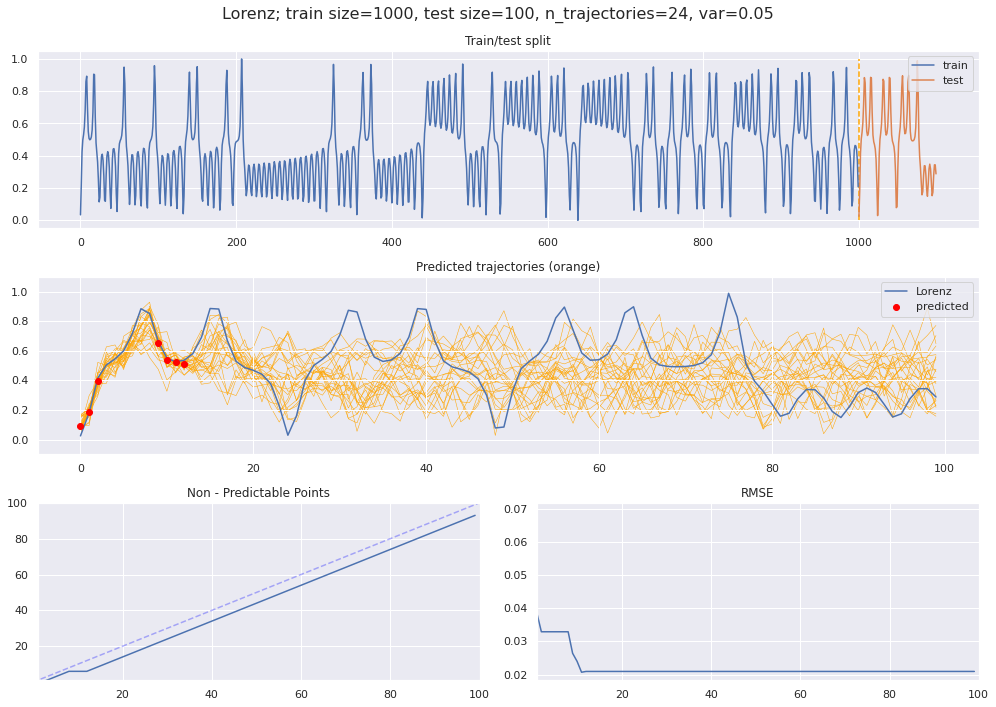

In [191]:
plot_trajectories(
    'Lorenz', X_train, X_test,
    noise_amp, n_trajectories,
    X_traj_pred, X_pred, non_pred, rmse
)

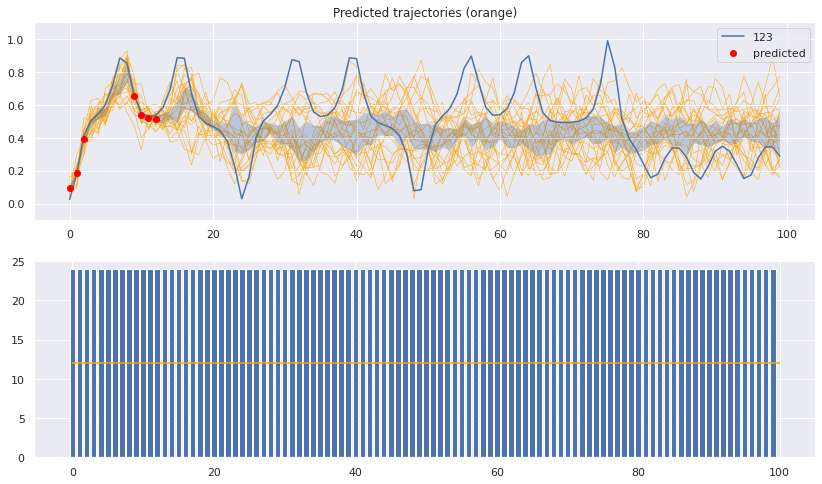

In [192]:
fig = plt.figure(figsize=[14, 8])

plt.subplot(2, 1, 1)
plt.plot(X_test, label='123', zorder=1)

plt.ylim(-0.1, 1.1)

for i in range(n_trajectories):
    plt.plot(X_traj_pred[:, i], c='orange', lw=0.5, zorder=0)

plt.scatter(range(X_pred.size),
            X_pred,
            label='predicted',
            c='red',
            zorder=2)

plt.fill_between(range(len(qs)), qs[:, 0], qs[:, 1], alpha=0.3)

plt.title('Predicted trajectories (orange)')
plt.legend(loc='upper right');

plt.subplot(2, 1, 2)
plt.bar(range(len(traj_alive)), traj_alive)
plt.hlines(y=min_trajectories, xmin=0, xmax=len(traj_alive), color='orange')

### single trajectory

In [193]:
X_traj_pred = tsp.predict_trajectories(
    X_start, h_max,
    eps=eps,
    n_trajectories=1,
    noise_amp=0,
    use_priori=False,
    X_test=None,
    priori_eps=priori_eps,
    save_first_type_non_pred=True,
    random_seed=1,
    n_jobs=-1,
)

3.34s


In [194]:
X_pred = X_traj_pred[:, 0]

In [195]:
non_pred = np.cumsum(np.isnan(X_pred).astype(int))
pred = np.cumsum(1 - np.isnan(X_pred).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((X_pred - X_test[:h_max])**2), nan=0)) /pred

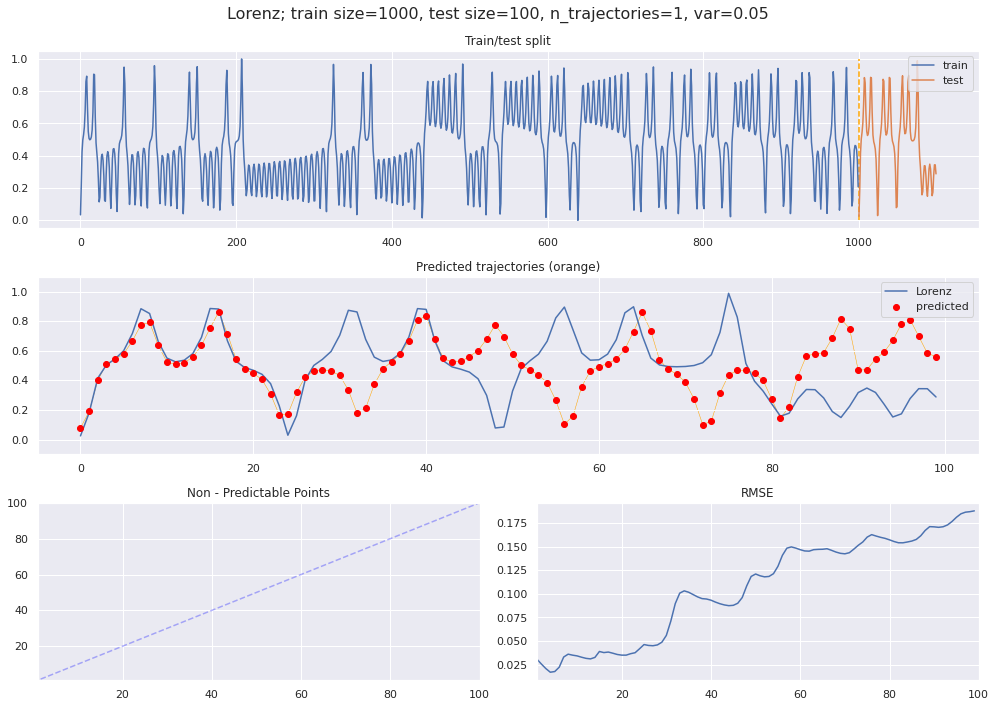

In [197]:
plot_trajectories(
    'Lorenz', X_train, X_test,
    noise_amp, 1,
    X_traj_pred, X_pred, non_pred, rmse
)

### use priori

In [198]:
X_traj_pred = tsp.predict_trajectories(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    use_priori=True,
    X_test=X_test,
    priori_eps=priori_eps,
    save_first_type_non_pred=False,
    random_seed=1,
    n_jobs=-1,
)

24.72s


In [206]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='quantile',
    use_priori=True,
    X_test=X_test,
    priori_eps=priori_eps,
    min_trajectories=min_trajectories,
    max_err=max_err,
    alpha=alpha,
    dbs_eps=0.01,
    dbs_min_samples=4,
)
X_pred = unified_result['X_pred']
qs = unified_result['qs']
traj_alive = unified_result['traj_alive']

In [207]:
non_pred = np.cumsum(np.isnan(X_pred).astype(int))
pred = np.cumsum(1 - np.isnan(X_pred).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((X_pred - X_test[:h_max])**2), nan=0)) /pred

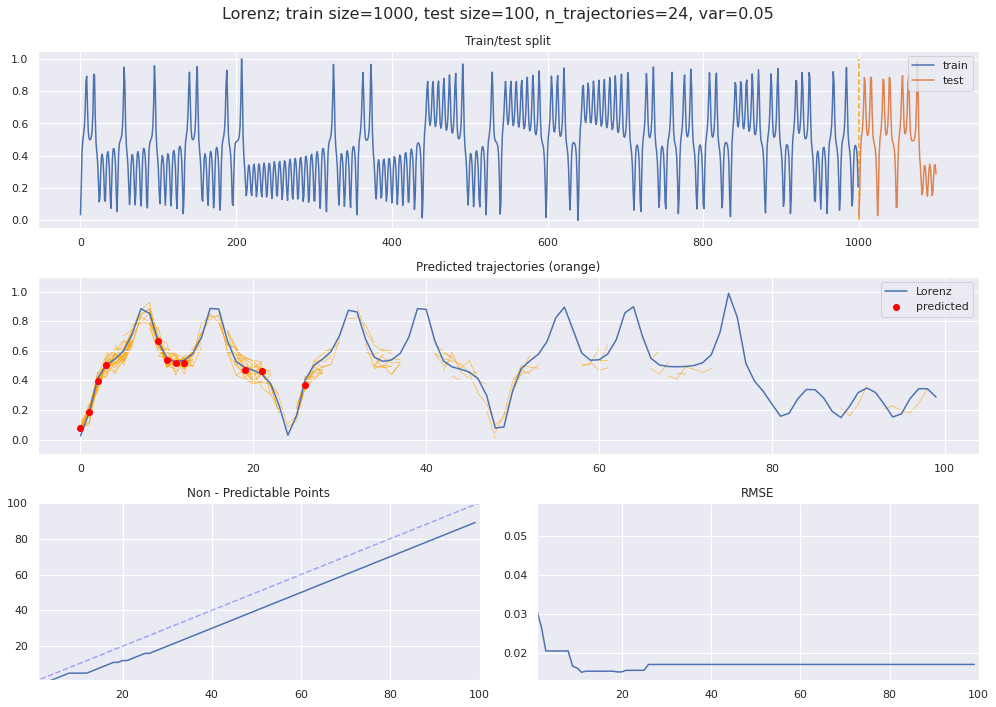

In [208]:
plot_trajectories(
    'Lorenz', X_train, X_test,
    noise_amp, n_trajectories,
    X_traj_pred, X_pred, non_pred, rmse
)

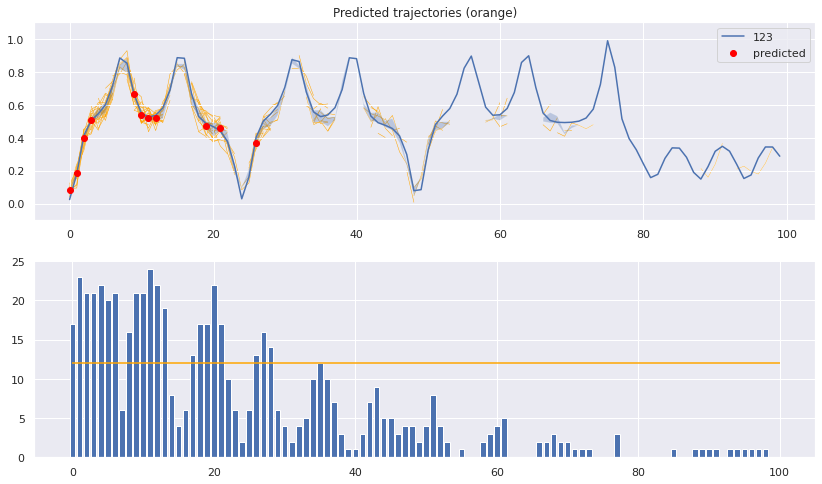

In [210]:
fig = plt.figure(figsize=[14, 8])

plt.subplot(2, 1, 1)
plt.plot(X_test, label='123', zorder=1)

plt.ylim(-0.1, 1.1)

for i in range(n_trajectories):
    plt.plot(X_traj_pred[:, i], c='orange', lw=0.5, zorder=0)

plt.scatter(range(X_pred.size),
            X_pred,
            label='predicted',
            c='red',
            zorder=2)

plt.fill_between(range(len(qs)), qs[:, 0], qs[:, 1], alpha=0.3)

plt.title('Predicted trajectories (orange)')
plt.legend(loc='upper right');

plt.subplot(2, 1, 2)
plt.bar(range(len(traj_alive)), traj_alive)
plt.hlines(y=min_trajectories, xmin=0, xmax=len(traj_alive), color='orange')